_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c7_interpolated_2100_100.csv")
training_set = data.iloc[:, 1]
training_set

0       92.600000
1       92.387115
2       92.174230
3       91.961345
4       91.748459
          ...    
2195    64.726160
2196    64.718508
2197    64.710856
2198    64.703204
2199    64.695552
Name: C7, Length: 2200, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(2100)
training_set

0       92.600000
1       92.387115
2       92.174230
3       91.961345
4       91.748459
          ...    
2095     0.527806
2096     0.609688
2097     0.000000
2098     0.000000
2099     0.000000
Name: C7, Length: 2100, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,92.600000,0.000298
1,92.387115,0.000298
2,92.174230,0.000297
3,91.961345,0.000297
4,91.748459,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

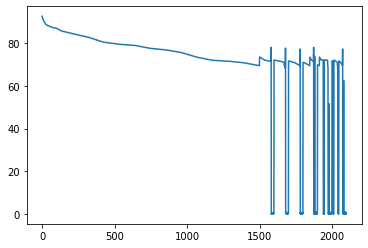

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

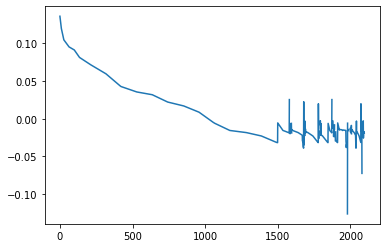

In [11]:
import numpy as np
c0 = 89.3180  # Value for C0
K0 = -0.0010  # Value for K0
K1 = 0.0001  # Value for K1
a = 0.0000    # Value for a
b = -0.0204    # Value for b
c = 2.2194    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    92.600000    92.387115    92.174230    91.961345    91.748459   
351    92.387115    92.174230    91.961345    91.748459    91.535574   
352    92.174230    91.961345    91.748459    91.535574    91.322689   
353    91.961345    91.748459    91.535574    91.322689    91.109804   
354    91.748459    91.535574    91.322689    91.109804    90.896919   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    91.535574    91.322689    91.109804    90.896919    90.691597  ...   
351    91.322689    91.109804    90.896919    90.691597    90.579552  ...   
352    91.109804    90.896919    90.691597    90.579552    90.467507  ...   
353    90.896919    90.691597    90.579552    90.467507    90.355462  ...   
354    90.691597    90.579552    90.467507    90.355462    90.243417  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   80.261671    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1650, 1, 251) (1650, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(89.3180, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0010, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(0.0001, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(-0.0204, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.2194, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
21/21 [==============================] - 2s 29ms/step - loss: 5708.0181 - val_loss: 3721.4072
Epoch 2/500
21/21 [==============================] - 0s 4ms/step - loss: 5635.1680 - val_loss: 3678.2966
Epoch 3/500
21/21 [==============================] - 0s 4ms/step - loss: 5570.1602 - val_loss: 3641.5171
Epoch 4/500
21/21 [==============================] - 0s 4ms/step - loss: 5505.6733 - val_loss: 3605.1289
Epoch 5/500
21/21 [==============================] - 0s 4ms/step - loss: 5441.7593 - val_loss: 3569.1187
Epoch 6/500
21/21 [==============================] - 0s 4ms/step - loss: 5378.4121 - val_loss: 3533.4785
Epoch 7/500
21/21 [==============================] - 0s 5ms/step - loss: 5315.6235 - val_loss: 3498.2024
Epoch 8/500
21/21 [==============================] - 0s 4ms/step - loss: 5253.3877 - val_loss: 3463.2871
Epoch 9/500
21/21 [==============================] - 0s 4ms/step - loss: 5191.6982 - val_loss: 3428.7288
Epoch 10/500
21/21 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 1s 530ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[7.11573529e+01, 7.10985294e+01, 7.10397059e+01, 6.98808824e+01,
        6.95210588e+01, 6.85264706e+01, 7.76552277e+01, 2.51280129e-01,
        0.00000000e+00, 7.14449644e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.16556233e+01, 7.16228501e+01, 7.15821895e+01,
        7.15233660e+01, 7.14645425e+01, 7.14057189e+01, 7.13468954e+01,
        7.12880719e+01, 7.12296484e+01, 7.11704248e+01, 7.11116013e+01,
        7.10532778e+01, 7.09939543e+01, 7.09351307e+01, 7.08526144e+01,
        7.07359673e+01, 7.06173203e+01, 7.04996732e+01, 7.03820261e+01,
        7.02643791e+01, 7.01467320e+01, 7.00290850e+01, 6.99114379e+01,
        6.97937908e+01, 6.96761438e+01, 6.95614947e+01, 6.94704248e+01,
        2.11114660e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.72564160e-02, 0.00000000e+00, 7.19315648e-01, 7.10070261e+01,
        7.09482026e+01, 7.08787582e+01, 7.07611111e+01, 7.06434641e+01,
        7.05258170e+01, 7.04081699e+01, 7.02905229e+01, 7.017287

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([65.52426471, 65.51446078, 65.50465686, 65.49485294, 65.48504902,
       65.4752451 , 65.46544118, 65.45563725, 65.44583333, 65.43602941,
       65.42622549, 65.41642157, 65.40661765, 65.39681373, 65.3870098 ,
       65.37720588, 65.36740196, 65.35759804, 65.34779412, 65.3379902 ,
       65.32818627, 65.31838235, 65.30857843, 65.29877451, 65.28897059,
       65.27916667, 65.26936275, 65.25955882, 65.2497549 , 65.23995098,
       65.23014706, 65.22034314, 65.21053922, 65.20073529, 65.19292205,
       65.18527021, 65.17761836, 65.16996652, 65.16231468, 65.15466284,
       65.147011  , 65.13935916, 65.13170732, 65.12405548, 65.11640363,
       65.10875179, 65.10109995, 65.09344811, 65.08579627, 65.07814443,
       65.07049259, 65.06284075, 65.0551889 , 65.04753706, 65.03988522,
       65.03223338, 65.02458154, 65.0169297 , 65.00927786, 65.00162602,
       64.99397418, 64.98632233, 64.97867049, 64.97101865, 64.96336681,
       64.95571497, 64.94806313, 64.94041129, 64.93275945, 64.92

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

41.266857679589286
29.473547891520138
